In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Step 1: Import necessary libraries
# We will use pandas, a powerful library for data manipulation and analysis in Python.
import pandas as pd
import numpy as np # Imported to handle potential errors during numeric conversion
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest


In [3]:
# Step 2: Load the datasets into pandas DataFrames
# We load the three provided CSV files into DataFrames with the specified names.
path = "/content/drive/MyDrive/Portfolio /Transaction_Fraud/cards_data.csv"
Cards_Data = pd.read_csv('/content/drive/MyDrive/Portfolio /Transaction_Fraud/cards_data.csv')
Cards_Data.head()

,id,client_id,card_brand,card_type,card_number,expires,cvv,has_chip,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed,card_on_dark_web
0,4524,825,Visa,Debit,4344676511950444,12/2022,623,YES,2,$24295,09/2002,2008,No
1,2731,825,Visa,Debit,4956965974959986,12/2020,393,YES,2,$21968,04/2014,2014,No
2,3701,825,Visa,Debit,4582313478255491,02/2024,719,YES,2,$46414,07/2003,2004,No
3,42,825,Visa,Credit,4879494103069057,08/2024,693,NO,1,$12400,01/2003,2012,No
4,4659,825,Mastercard,Debit (Prepaid),5722874738736011,03/2009,75,YES,1,$28,09/2008,2009,No


In [4]:
path1 = "/content/drive/MyDrive/Portfolio /Transaction_Fraud/transaction_data.csv"
transactions_data = pd.read_csv('/content/drive/MyDrive/Portfolio /Transaction_Fraud/transaction_data.csv')
transactions_data.head()

,id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors
0,7475327,1/1/2010 0:01,1556,2972,($77.00),Swipe Transaction,59935,Beulah,ND,58523.0,5499,NaN
1,7475328,1/1/2010 0:02,561,4575,$14.57,Swipe Transaction,67570,Bettendorf,IA,52722.0,5311,NaN
2,7475329,1/1/2010 0:02,1129,102,$80.00,Swipe Transaction,27092,Vista,CA,92084.0,4829,NaN
3,7475331,1/1/2010 0:05,430,2860,$200.00,Swipe Transaction,27092,Crown Point,IN,46307.0,4829,NaN
4,7475332,1/1/2010 0:06,848,3915,$46.41,Swipe Transaction,13051,Harwood,MD,20776.0,5813,NaN


In [5]:
path2 = "/content/drive/MyDrive/Portfolio /Transaction_Fraud/users_data.csv"
users_data = pd.read_csv('/content/drive/MyDrive/Portfolio /Transaction_Fraud/users_data.csv')
users_data.head()

,id,current_age,retirement_age,birth_year,birth_month,gender,address,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards
0,825,53,66,1966,11,Female,462 Rose Lane,34.15,-117.76,$29278,$59696,$127613,787,5
1,1746,53,68,1966,12,Female,3606 Federal Boulevard,40.76,-73.74,$37891,$77254,$191349,701,5
2,1718,81,67,1938,11,Female,766 Third Drive,34.02,-117.89,$22681,$33483,$196,698,5
3,708,63,63,1957,1,Female,3 Madison Street,40.71,-73.99,$163145,$249925,$202328,722,4
4,1164,43,70,1976,9,Male,9620 Valley Stream Drive,37.76,-122.44,$53797,$109687,$183855,675,1


In [6]:
# Step 3: Clean and Prepare the `transactions_data` DataFrame

# Rename columns for clarity and consistency before merging.
# 'client_id' is renamed to 'user_id' to match the 'users_data' table.
transactions_data.rename(columns={'client_id': 'user_id'}, inplace=True)
print("       - Renamed 'client_id' to 'user_id'.")

       - Renamed 'client_id' to 'user_id'.


In [7]:
# Convert the 'date' column from a text object to a proper datetime format.
# This is crucial for any time-series analysis.
transactions_data['date'] = pd.to_datetime(transactions_data['date'])
print("       - Converted 'date' column to datetime objects.")

       - Converted 'date' column to datetime objects.


In [8]:
# Clean the 'amount' column. It is currently a text object with '$' and '()' characters.
# We remove these characters and convert the column to a numeric (float) type.
# The errors='coerce' argument will turn any values that can't be converted into 'NaN' (Not a Number).
#Step Convert negative parentheses to minus sign
transactions_data['amount'] = transactions_data['amount'].replace({r'\(([^)]+)\)': r'-\1'}, regex=True)
#Step Remove dollar signs and commas
transactions_data['amount'] = transactions_data['amount'].replace({r'[\$,]': ''}, regex=True)
##Step Convert column to numeric
transactions_data['amount'] = pd.to_numeric(transactions_data['amount'], errors='coerce')

print("       - Cleaned and converted 'amount' column to a numeric type.")

       - Cleaned and converted 'amount' column to a numeric type.


In [9]:
# Step 4: Clean and Prepare the `users_data` DataFrame
print("\nStep 4: Cleaning 'users_data' DataFrame...")


Step 4: Cleaning 'users_data' DataFrame...


In [10]:
# Rename the 'id' column to 'user_id' to serve as the primary key for merging.
users_data.rename(columns={'id': 'user_id'}, inplace=True)
print("       - Renamed 'id' to 'user_id'.")

       - Renamed 'id' to 'user_id'.


In [11]:
# Clean the financial columns ('yearly_income', 'per_capita_income', 'total_debt').
# Like the 'amount' column, these are text objects that need to be converted to numeric types.
financial_cols = ['yearly_income', 'per_capita_income', 'total_debt']
for col in financial_cols:
    users_data[col] = users_data[col].replace({r'[\$,]': ''}, regex=True)
    users_data[col] = pd.to_numeric(users_data[col], errors='coerce')
print("       - Cleaned and converted financial columns to numeric types.")

       - Cleaned and converted financial columns to numeric types.


In [12]:
# Step 5: Clean and Prepare the `Cards_Data` DataFrame
print("\nStep 5: Cleaning 'Cards_Data' DataFrame...")


Step 5: Cleaning 'Cards_Data' DataFrame...


In [13]:
# Rename columns for consistency and to prepare for merging.
Cards_Data.rename(columns={'id': 'card_id', 'client_id': 'user_id'}, inplace=True)
print("       - Renamed 'id' to 'card_id' and 'client_id' to 'user_id'.")

       - Renamed 'id' to 'card_id' and 'client_id' to 'user_id'.


In [14]:
# Clean the 'credit_limit' column by removing '$' and converting it to a numeric type.
Cards_Data['credit_limit'] = Cards_Data['credit_limit'].replace({r'[\$,]': ''}, regex=True)
Cards_Data['credit_limit'] = pd.to_numeric(Cards_Data['credit_limit'], errors='coerce')
print("       - Cleaned and converted 'credit_limit' column to a numeric type.")

       - Cleaned and converted 'credit_limit' column to a numeric type.


In [15]:
# Convert date-related columns to datetime objects.
Cards_Data['acct_open_date'] = pd.to_datetime(Cards_Data['acct_open_date'])
Cards_Data['expires'] = pd.to_datetime(Cards_Data['expires'], format='%m/%Y')
print("       - Converted date columns ('acct_open_date', 'expires') to datetime objects.")

       - Converted date columns ('acct_open_date', 'expires') to datetime objects.


/tmp/ipython-input-15-2291466900.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  Cards_Data['acct_open_date'] = pd.to_datetime(Cards_Data['acct_open_date'])


In [16]:
# Step 6: Merge the Cleaned DataFrames
print("\nStep 6: Merging the DataFrames into a single, unified dataset...")


Step 6: Merging the DataFrames into a single, unified dataset...


In [17]:
# First, merge 'transactions_data' with 'Cards_Data' on 'card_id'.
# We use a 'left' merge to ensure all transactions are kept, even if there's no matching card data.
merged_df = pd.merge(transactions_data, Cards_Data, on='card_id', how='left', suffixes=('', '_card'))

In [18]:
# Next, merge the result with 'users_data' on 'user_id'.
# This adds the user's demographic and financial information to each transaction.
# We drop the redundant 'user_id_card' column that came from the first merge.
if 'user_id_card' in merged_df.columns:
    merged_df.drop(columns=['user_id_card'], inplace=True)
final_df = pd.merge(merged_df, users_data, on='user_id', how='left')

print("       - Merging complete.")
print(f"       - Shape of the final merged DataFrame: {final_df.shape}")

       - Merging complete.
       - Shape of the final merged DataFrame: (5000, 36)


In [19]:
# Step 7: Final Verification
print("\nStep 7: Verifying the final cleaned and merged DataFrame.")


Step 7: Verifying the final cleaned and merged DataFrame.


In [20]:
# Display the first 5 rows to give a snapshot of the final structure.
print("\n--- Final DataFrame Head ---")
final_df.head()


--- Final DataFrame Head ---


,id,date,user_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,...,birth_month,gender,address,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards
0,7475327,2010-01-01 00:01:00,1556,2972,-77.00,Swipe Transaction,59935,Beulah,ND,58523.0,...,7,Female,594 Mountain View Street,46.80,-100.76,23679,48277,110153,740,4
1,7475328,2010-01-01 00:02:00,561,4575,14.57,Swipe Transaction,67570,Bettendorf,IA,52722.0,...,6,Male,604 Pine Street,40.80,-91.12,18076,36853,112139,834,5
2,7475329,2010-01-01 00:02:00,1129,102,80.00,Swipe Transaction,27092,Vista,CA,92084.0,...,4,Male,2379 Forest Lane,33.18,-117.29,16894,34449,36540,686,3
3,7475331,2010-01-01 00:05:00,430,2860,200.00,Swipe Transaction,27092,Crown Point,IN,46307.0,...,5,Female,903 Hill Boulevard,41.42,-87.35,26168,53350,128676,685,5
4,7475332,2010-01-01 00:06:00,848,3915,46.41,Swipe Transaction,13051,Harwood,MD,20776.0,...,5,Male,166 River Drive,38.86,-76.60,33529,68362,96182,711,2


In [21]:
# Display the DataFrame's info to confirm data types have been corrected and to check for null values.
print("\n--- Final DataFrame Info ---")
final_df.info()


--- Final DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 36 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   id                     5000 non-null   int64         
 1   date                   5000 non-null   datetime64[ns]
 2   user_id                5000 non-null   int64         
 3   card_id                5000 non-null   int64         
 4   amount                 5000 non-null   float64       
 5   use_chip               5000 non-null   object        
 6   merchant_id            5000 non-null   int64         
 7   merchant_city          5000 non-null   object        
 8   merchant_state         4365 non-null   object        
 9   zip                    4356 non-null   float64       
 10  mcc                    5000 non-null   int64         
 11  errors                 74 non-null     object        
 12  card_brand             5000 non-

## Analysis phase
Advanced Analysis Python Code


In [22]:
# --- Part 1: Clean the Dataset ---
# This step clean the final, pre-processed dataset you provided.
# Clean up by dropping the common 'Unnamed: 0' column if it exists
if 'Unnamed: 0' in final_df.columns:
  final_df = final_df.drop('Unnamed: 0', axis=1)

In [23]:
# Ensure date columns are in the correct datetime format for time-series analysis
for col in ['date', 'expires', 'acct_open_date']:
  if col in final_df.columns:
    final_df[col] = pd.to_datetime(final_df[col], errors='coerce')

In [24]:
# --- Part 2: Comprehensive Feature Engineering ---
# This is where we create new, insightful features to describe the context of each transaction.

In [25]:
# if you’ve merged once already, get rid of the stale columns
for col in ['user_mean','user_std']:
    if col in final_df.columns:
        final_df.drop(col, axis=1, inplace=True)


In [26]:
if not final_df.empty:
  final_df.sort_values(by=['user_id', 'date'], inplace=True)
  # a) User Spending Z-score: How unusual is this transaction amount for this specific user?
  user_stats = final_df.groupby('user_id')['amount'].agg(['mean', 'std']).rename(columns={'mean': 'user_mean', 'std': 'user_std'})
  final_df = final_df.merge(user_stats, on='user_id', how='left')
  final_df['user_std'].fillna(0, inplace=True)
  final_df['amount_z_score'] = ((final_df['amount'] - final_df['user_mean']) / (final_df['user_std'] + 1e-6)).fillna(0)
  # b) Transaction Velocity: How long has it been since this user's last transaction?
  final_df['time_since_last_txn_hours'] = final_df.groupby('user_id')['date'].diff().dt.total_seconds() / 3600
  final_df['time_since_last_txn_hours'].fillna(final_df['time_since_last_txn_hours'].median(), inplace=True)
  # c) Time-based Features: Does the transaction occur at a risky time?
  final_df['hour'] = final_df['date'].dt.hour
  final_df['is_night'] = ((final_df['hour'] >= 0) & (final_df['hour'] <= 6)).astype(int)
  print("Feature engineering complete.")


Feature engineering complete.


/tmp/ipython-input-26-1558280590.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  final_df['user_std'].fillna(0, inplace=True)
/tmp/ipython-input-26-1558280590.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try

In [28]:
# --- Part 3: Data Scaling for Modeling ---
if not final_df.empty:
    features_for_model = [
        'amount', 'amount_z_score', 'time_since_last_txn_hours',
        'is_night', 'credit_score', 'yearly_income'
    ]
    model_data = final_df[features_for_model].copy()
    model_data.fillna(model_data.median(), inplace=True)

    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(model_data)
    print("Data scaling complete.")


Data scaling complete.


In [29]:
# --- Part 4: Anomaly Detection with Isolation Forest ---
if not final_df.empty:
    # We expect a small percentage of transactions to be anomalies (e.g., 5%)
    model = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
    model.fit(scaled_data)

    final_df['anomaly_score'] = model.decision_function(scaled_data)
    final_df['is_anomaly'] = model.predict(scaled_data)
    print("Anomaly detection model trained and applied.")

Anomaly detection model trained and applied.


In [ ]:
# --- Part 5: Results and Interpretation ---
if not final_df.empty:
    anomalies = final_df[final_df['is_anomaly'] == -1].sort_values(by='anomaly_score')

    print(f"\nModel identified {len(anomalies)} potential anomalies.")
    print("\n--- Detailed Report for Top 5 Anomalies ---")

    for i, anomaly in anomalies.head(5).iterrows():
        print(f"\n--- Anomaly Rank #{i+1} (Transaction ID: {anomaly['id']}) ---")
        print(f"  - Anomaly Score: {anomaly['anomaly_score']:.4f} (Lower is more anomalous)")
        print(f"  - Transaction Details: ${anomaly['amount']:.2f} at {anomaly['date']}")
        print("\n  - Key Contributing Factors:")
        if anomaly['is_night'] == 1:
            print(f"    - Unusual Time: Transaction occurred at night ({anomaly['hour']}:00).")
        if abs(anomaly['amount_z_score']) > 2:
            print(f"    - Unusual Spending for User: Amount was {abs(anomaly['amount_z_score']):.2f} standard deviations from the user's average.")
        if anomaly['time_since_last_txn_hours'] < 0.1:
            print(f"    - High Velocity: Occurred only {anomaly['time_since_last_txn_hours']*60:.1f} minutes after the last transaction.")


Model identified 250 potential anomalies.

--- Detailed Report for Top 5 Anomalies ---

--- Anomaly Rank #2793 (Transaction ID: 7478981) ---
  - Anomaly Score: -0.1333 (Lower is more anomalous)
  - Transaction Details: $583.16 at 2010-01-01 20:19:00

  - Key Contributing Factors:
    - Unusual Spending for User: Amount was 3.03 standard deviations from the user's average.

--- Anomaly Rank #4193 (Transaction ID: 7479699) ---
  - Anomaly Score: -0.1230 (Lower is more anomalous)
  - Transaction Details: $40.13 at 2010-01-02 06:21:00

  - Key Contributing Factors:
    - Unusual Time: Transaction occurred at night (6:00).

--- Anomaly Rank #2770 (Transaction ID: 7479731) ---
  - Anomaly Score: -0.1192 (Lower is more anomalous)
  - Transaction Details: $200.00 at 2010-01-02 06:31:00

  - Key Contributing Factors:
    - Unusual Time: Transaction occurred at night (6:00).

--- Anomaly Rank #893 (Transaction ID: 7479513) ---
  - Anomaly Score: -0.1183 (Lower is more anomalous)
  - Transaction

## The Share Phase


In [ ]:
# --- Part 1: Visualizing Key Insights for Analysts ---


--- Part 2: Generating a Comparison Plot for Analysts ---


/tmp/ipython-input-33-3528087810.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(['Anomaly', 'Normal'] if sorted(night_comparison['is_anomaly'].unique()) == [-1, 1] else ['Normal', 'Anomaly'])


Generated 'anomaly_characteristics_comparison.png' for deeper analysis.


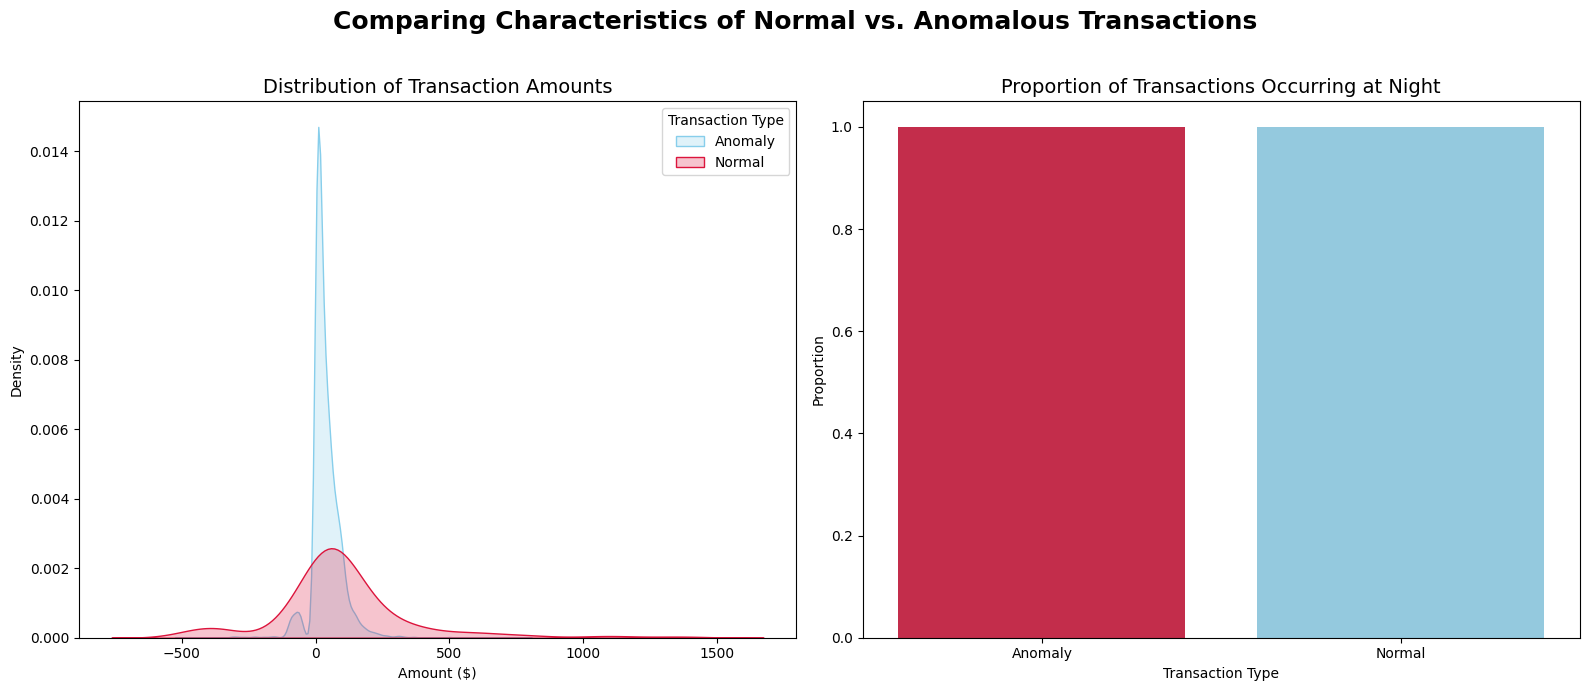

In [33]:
# This visual helps answer the "why" question. What makes these anomalies different?
if not final_df.empty:
    print("\n--- Part 2: Generating a Comparison Plot for Analysts ---")

    # Set up figure with two plots
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    fig.suptitle('Comparing Characteristics of Normal vs. Anomalous Transactions', fontsize=18, weight='bold')

    # Plot 1: Distribution of transaction amounts
    sns.kdeplot(
        data=final_df,
        x='amount',
        hue='is_anomaly',
        fill=True,
        palette={1: 'skyblue', -1: 'crimson'},
        ax=axes[0],
        common_norm=False
    )
    axes[0].set_title('Distribution of Transaction Amounts', fontsize=14)
    axes[0].set_xlabel('Amount ($)')
    axes[0].set_ylabel('Density')
    axes[0].legend(title='Transaction Type', labels=['Anomaly', 'Normal'])

    # Prepare data for Plot 2: Proportion of transactions at night
    night_comparison = (
        final_df[final_df['is_night'] == True]
        .groupby('is_anomaly')['is_night']
        .value_counts(normalize=True)
        .rename('proportion')
        .reset_index()
    )

    # Plot 2: Nighttime transaction proportions
    sns.barplot(
        data=night_comparison,
        x='is_anomaly',
        y='proportion',
        hue='is_anomaly',
        dodge=False,
        palette={1: 'skyblue', -1: 'crimson'},
        ax=axes[1],
        legend=False  # Hue acts as color map, legend not needed here
    )
    axes[1].set_title('Proportion of Transactions Occurring at Night', fontsize=14)
    axes[1].set_xlabel('Transaction Type')
    axes[1].set_ylabel('Proportion')
    axes[1].set_xticklabels(['Anomaly', 'Normal'] if sorted(night_comparison['is_anomaly'].unique()) == [-1, 1] else ['Normal', 'Anomaly'])

    # Final layout adjustments and save
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig('anomaly_characteristics_comparison.png')
    print("Generated 'anomaly_characteristics_comparison.png' for deeper analysis.")

In [35]:
# This is the most crucial output for the fraud investigation team.
# It's a clear, text-based report they can act on immediately.
if not final_df.empty:
    print("\n--- Part 3: Generating the Actionable Anomaly Report ---")

    # Prepare the report header
    report_string = "Top 5 Most Suspicious Transactions for Immediate Review\n"
    report_string += "=" * 60 + "\n"

    # Select relevant columns (optional: for export or filtering)
    report_cols = ['id', 'user_id', 'date', 'amount', 'anomaly_score', 'amount_z_score', 'is_night']

    # Extract anomalies from the dataframe
    anomalies = final_df[final_df['is_anomaly'] == -1]

    # Loop through top 5 most suspicious transactions
    for i, anomaly in anomalies.sort_values(by='anomaly_score').head(5).iterrows():
        report_string += f"\nRank #{i+1} | Transaction ID: {anomaly['id']}\n"
        report_string += "---------------------------------------------------\n"
        report_string += f"  - Anomaly Score: {anomaly['anomaly_score']:.4f} (The lower, the more suspicious)\n"
        report_string += f"  - User ID:       {anomaly['user_id']}\n"
        report_string += f"  - Date & Time:   {anomaly['date']}\n"
        report_string += f"  - Amount:        ${anomaly['amount']:.2f}\n"
        report_string += "\n  - Why it was flagged:\n"

        # Add automated reasoning based on features
        if abs(anomaly['amount_z_score']) > 2:
            report_string += f"    * Spending Anomaly: This amount is {abs(anomaly['amount_z_score']):.1f} standard deviations away from this user's typical spending.\n"
        if anomaly['is_night']:
            report_string += "    * Time Anomaly: This transaction occurred during high-risk, late-night hours.\n"

    # Print the final report to the console
    print("\n--- ACTIONABLE REPORT ---\n")
    print(report_string)

    # Save the report to a text file
    with open('actionable_anomaly_report.txt', 'w') as f:
        f.write(report_string)
    print("\nSaved the detailed report to 'actionable_anomaly_report.txt'.")


--- Part 3: Generating the Actionable Anomaly Report ---

--- ACTIONABLE REPORT ---

Top 5 Most Suspicious Transactions for Immediate Review

Rank #2793 | Transaction ID: 7478981
---------------------------------------------------
  - Anomaly Score: -0.1333 (The lower, the more suspicious)
  - User ID:       1168
  - Date & Time:   2010-01-01 20:19:00
  - Amount:        $583.16

  - Why it was flagged:
    * Spending Anomaly: This amount is 3.0 standard deviations away from this user's typical spending.

Rank #4193 | Transaction ID: 7479699
---------------------------------------------------
  - Anomaly Score: -0.1230 (The lower, the more suspicious)
  - User ID:       1692
  - Date & Time:   2010-01-02 06:21:00
  - Amount:        $40.13

  - Why it was flagged:
    * Time Anomaly: This transaction occurred during high-risk, late-night hours.

Rank #2770 | Transaction ID: 7479731
---------------------------------------------------
  - Anomaly Score: -0.1192 (The lower, the more suspic